In [1]:
import pickle
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
import glob as glob
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from collections import defaultdict
from scipy.stats import spearmanr
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import scipy.ndimage
import matplotlib.colors as mcolors
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.mixture import GaussianMixture
from scipy.optimize import fsolve
from tqdm import tqdm

In [2]:
file_name = "degraded_clear_only_v4_AnalysisDegraded_230322_214006_Jamie.pickle"
file_path = "/home/marcush/Data/TsaoLabData/split/degraded"
data_path = os.path.join(file_path, file_name)


with open(data_path, 'rb') as file:
    raw_data = pickle.load(file)

# Get Data

In [3]:
StimulusOFFDurations = raw_data['off_durations']
StimulusONDurations = raw_data['on_durations']
TrialDurations = StimulusONDurations + StimulusOFFDurations

stimIDs = raw_data['stimulus_index_valid']

ML_region_ind = raw_data['regions'].index('ML')
ML_unit_inds = np.where(raw_data['regionIDs'] == ML_region_ind)[0]
ML_numUnits = len(ML_unit_inds)


AM_region_ind = raw_data['regions'].index('AM')
AM_unit_inds = np.where(raw_data['regionIDs'] == AM_region_ind)[0]
AM_numUnits = len(AM_unit_inds)


numTrials = len(raw_data['trial_durations'])
TrialStartTimes = raw_data['timecourse_on_times'] 
BinarySpikeTimes_ML = raw_data['timecourse_all_units'][:, ML_unit_inds]
BinarySpikeTimes_AM = raw_data['timecourse_all_units'][:, AM_unit_inds]

In [4]:
SpikeMats_ML = np.empty(shape=(numTrials, ML_numUnits), dtype='object')

for trialInd, trialStartTime in enumerate(TrialStartTimes):

    # Get the relevant section of the response matrix
    spikes = BinarySpikeTimes_ML[int(trialStartTime):int(trialStartTime+TrialDurations[trialInd]), :]

    for unit in range(ML_numUnits):
        # for each neuron, convert binary spike vector to spike times relative to trial onset
        spikeTimes = np.nonzero(spikes[:,unit]) # units of ms

        SpikeMats_ML[trialInd, unit] = spikeTimes



SpikeMats_AM = np.empty(shape=(numTrials, AM_numUnits), dtype='object')

for trialInd, trialStartTime in enumerate(TrialStartTimes):

    # Get the relevant section of the response matrix
    spikes = BinarySpikeTimes_AM[int(trialStartTime):int(trialStartTime+TrialDurations[trialInd]), :]

    for unit in range(AM_numUnits):
        # for each neuron, convert binary spike vector to spike times relative to trial onset
        spikeTimes = np.nonzero(spikes[:,unit]) # units of ms

        SpikeMats_AM[trialInd, unit] = spikeTimes

Text(0.5, 0, 'Trial Number')

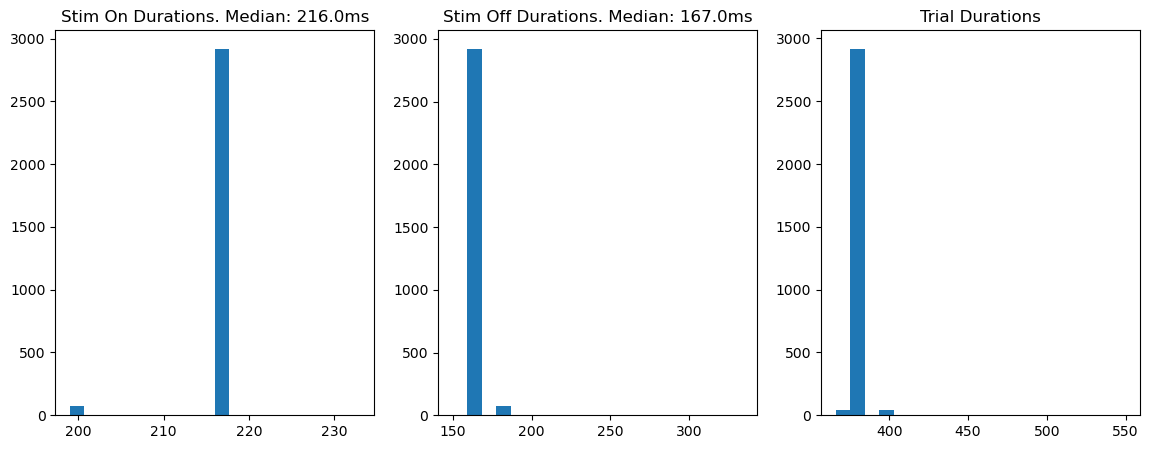

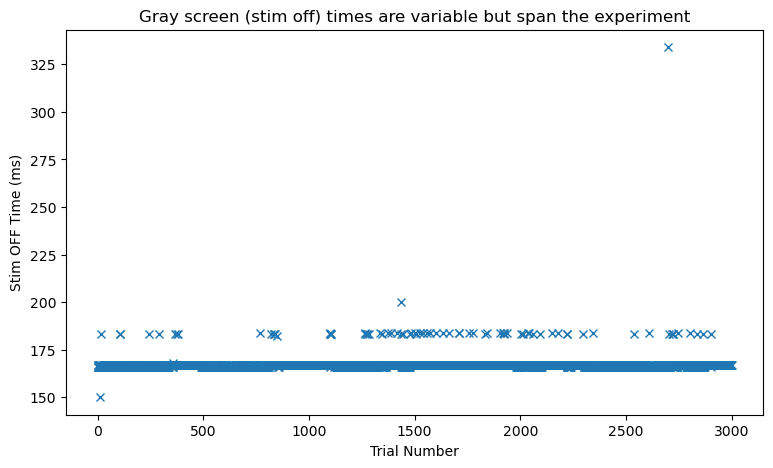

In [9]:
plt.figure(figsize=(14, 5))

plt.subplot(1,3,1)
median_stim_on_time = np.median(StimulusONDurations)
plt.hist(StimulusONDurations, 20)
plt.title(f"Stim On Durations. Median: {median_stim_on_time}ms")


plt.subplot(1,3,2)
median_stim_off_time = np.median(StimulusOFFDurations)
plt.hist(StimulusOFFDurations, 20)
plt.title(f"Stim Off Durations. Median: {median_stim_off_time}ms")

plt.subplot(1,3,3)
plt.hist(TrialDurations, 20)
plt.title("Trial Durations")

plt.figure(figsize=(9, 5))
plt.plot(StimulusOFFDurations, 'x')
plt.title("Gray screen (stim off) times are variable but span the experiment")
plt.ylabel("Stim OFF Time (ms)")
plt.xlabel("Trial Number")

In [10]:
window = median_stim_on_time+0              # the time after which we'll look for baseline responses
stim_off_min_time = 0       # minimum amount of time to compute baseline


print(f"Number of trials used to estimate baseline: {np.sum(np.logical_and(StimulusOFFDurations > stim_off_min_time, TrialDurations > window))}")

AM_spont_rates_all = {}
AM_spont_rates = np.zeros(AM_numUnits)
AM_all_counts = np.zeros((numTrials, AM_numUnits))
for unit in np.arange(AM_numUnits):
    AM_spont_rates_all[unit] = []
    spont_rates = []
    for trial in np.arange(numTrials):
        AM_all_counts[trial, unit] += len(SpikeMats_AM[trial, unit][0])

        if StimulusOFFDurations[trial] > stim_off_min_time and TrialDurations[trial] > window: 
            sp_times = SpikeMats_AM[trial, unit][0]
            sp_times = sp_times[sp_times > window] # isolate baseline response
            sp_count_baseline = len(sp_times)
            spont_rates.append((sp_count_baseline / StimulusOFFDurations[trial]) * 1000) # turn into spikes/s
            AM_spont_rates_all[unit] = np.hstack((AM_spont_rates_all[unit], (sp_count_baseline / StimulusOFFDurations[trial])*1000))
    AM_spont_rates[unit] = np.mean(spont_rates)


ML_spont_rates_all = {}
ML_spont_rates = np.zeros(ML_numUnits)
ML_all_counts = np.zeros((numTrials, ML_numUnits))
for unit in np.arange(ML_numUnits):
    ML_spont_rates_all[unit] = []
    spont_rates = []
    for trial in np.arange(numTrials):
        ML_all_counts[trial, unit] += len(SpikeMats_ML[trial, unit][0])

        if StimulusOFFDurations[trial] > stim_off_min_time: #estimate baseline spike rate if we have more than 200ms of estimate
            sp_times = SpikeMats_ML[trial, unit][0]
            sp_times = sp_times[sp_times > window] # isolate baseline response
            sp_count_baseline = len(sp_times)
            spont_rates.append((sp_count_baseline / StimulusOFFDurations[trial]) * 1000) # turn into spikes/s
            ML_spont_rates_all[unit] = np.hstack((ML_spont_rates_all[unit], (sp_count_baseline / StimulusOFFDurations[trial])*1000))
            
    ML_spont_rates[unit] = np.mean(spont_rates)


AM_sort_inds_base = np.argsort(AM_spont_rates)
ML_sort_inds_base = np.argsort(ML_spont_rates)


Number of trials used to estimate baseline: 3001


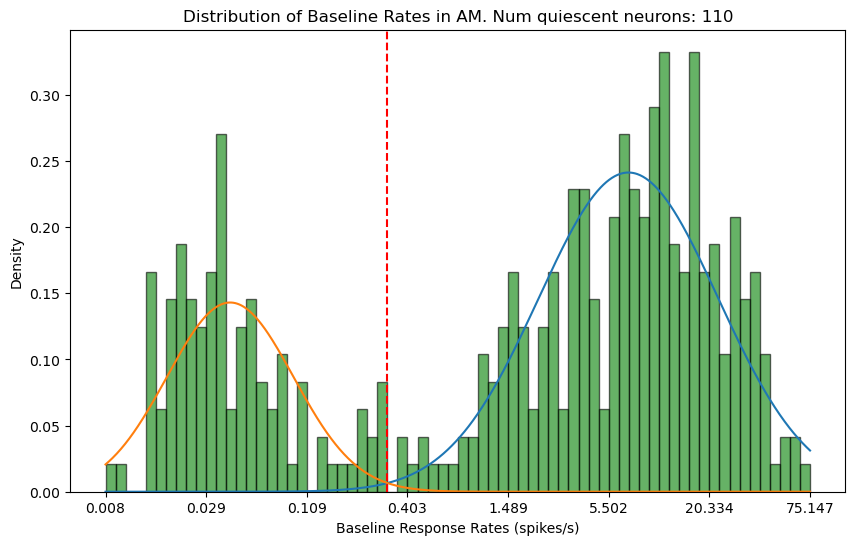

The intersection point of the two Gaussians is at x = 0.311 spikes/s
The cumulative count below the intersection point is 110


In [11]:
nbins = 70
data = AM_spont_rates
data = data[data > 0] # remove non-firing baseline units
data = np.log(data)  # plot on log scale

# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=0).fit(data.reshape(-1, 1))
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_

# Define the two Gaussian functions
def gaussian(x, mean, cov, weight):
    return weight * np.exp(-0.5 * ((x - mean) ** 2) / cov) / np.sqrt(2 * np.pi * cov)

# Define the function to find the intersection
def intersection(x):
    return gaussian(x, means[0], covariances[0], weights[0]) - gaussian(x, means[1], covariances[1], weights[1])

# Find the intersection point
x_intersection = fsolve(intersection, x0=np.mean(means))[0]

# Compute the histogram and cumulative counts
counts, bin_edges = np.histogram(data, bins=nbins)
cumulative_counts = np.cumsum(counts)

# Find the cumulative count up to the intersection point
intersection_bin_index = np.searchsorted(bin_edges, x_intersection, side='right')
cumulative_count_at_intersection = cumulative_counts[intersection_bin_index - 1] if intersection_bin_index > 0 else 0

# Plot the data and the fitted Gaussians
x = np.linspace(min(data), max(data), 1000)
g1 = gaussian(x, means[0], covariances[0], weights[0])
g2 = gaussian(x, means[1], covariances[1], weights[1])

plt.figure(figsize=(10, 6))
plt.hist(data, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black')  
plt.plot(x, g1, label='Mode 1')
plt.plot(x, g2, label='Mode 2')
nticks = 10; 
plt.xticks(ticks=bin_edges[::nticks], labels=np.round(np.exp(bin_edges[::nticks]), 3))

plt.axvline(x=x_intersection, color='r', linestyle='--', label=f'Intersection')
#plt.legend()
plt.xlabel('Baseline Response Rates (spikes/s)')
plt.ylabel('Density')
plt.title(f'Distribution of Baseline Rates in AM. Num quiescent neurons: {cumulative_count_at_intersection}')
plt.show()

# Print the intersection point and the cumulative count
print(f"The intersection point of the two Gaussians is at x = {np.exp(x_intersection):.3f} spikes/s")
print(f"The cumulative count below the intersection point is {cumulative_count_at_intersection}")
num_quiescent_neurons_removed_AM = cumulative_count_at_intersection

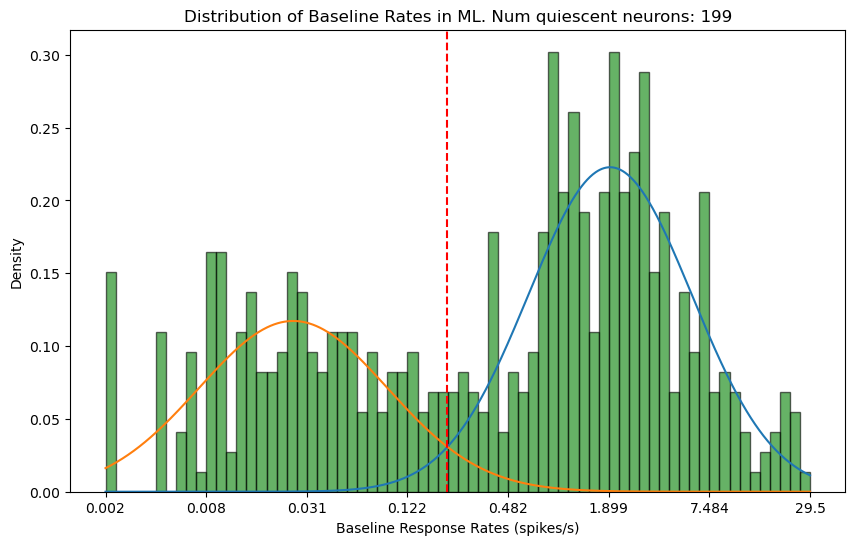

The intersection point of the two Gaussians is at x = 0.211 spikes/s
The cumulative count below the intersection point is 199


In [12]:
nbins = 70
data = ML_spont_rates
data = data[data > 0] # remove non-firing baseline units
data = np.log(data)  # plot on log scale

# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=0).fit(data.reshape(-1, 1))
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_

# Define the two Gaussian functions
def gaussian(x, mean, cov, weight):
    return weight * np.exp(-0.5 * ((x - mean) ** 2) / cov) / np.sqrt(2 * np.pi * cov)

# Define the function to find the intersection
def intersection(x):
    return gaussian(x, means[0], covariances[0], weights[0]) - gaussian(x, means[1], covariances[1], weights[1])

# Find the intersection point
x_intersection = fsolve(intersection, x0=np.mean(means))[0]

# Compute the histogram and cumulative counts
counts, bin_edges = np.histogram(data, bins=nbins)
cumulative_counts = np.cumsum(counts)

# Find the cumulative count up to the intersection point
intersection_bin_index = np.searchsorted(bin_edges, x_intersection, side='right')
cumulative_count_at_intersection = cumulative_counts[intersection_bin_index - 1] if intersection_bin_index > 0 else 0

# Plot the data and the fitted Gaussians
x = np.linspace(min(data), max(data), 1000)
g1 = gaussian(x, means[0], covariances[0], weights[0])
g2 = gaussian(x, means[1], covariances[1], weights[1])

plt.figure(figsize=(10, 6))
plt.hist(data, bins=nbins, density=True, alpha=0.6, color='g', edgecolor='black')  
plt.plot(x, g1, label='Mode 1')
plt.plot(x, g2, label='Mode 2')
nticks = 10; 
plt.xticks(ticks=bin_edges[::nticks], labels=np.round(np.exp(bin_edges[::nticks]), 3))

plt.axvline(x=x_intersection, color='r', linestyle='--', label=f'Intersection')
#plt.legend()
plt.xlabel('Baseline Response Rates (spikes/s)')
plt.ylabel('Density')
plt.title(f'Distribution of Baseline Rates in ML. Num quiescent neurons: {cumulative_count_at_intersection}')
plt.show()

# Print the intersection point and the cumulative count
print(f"The intersection point of the two Gaussians is at x = {np.exp(x_intersection):.3f} spikes/s")
print(f"The cumulative count below the intersection point is {cumulative_count_at_intersection}")
num_quiescent_neurons_removed_ML = cumulative_count_at_intersection


Text(0, 0.5, 'ML')

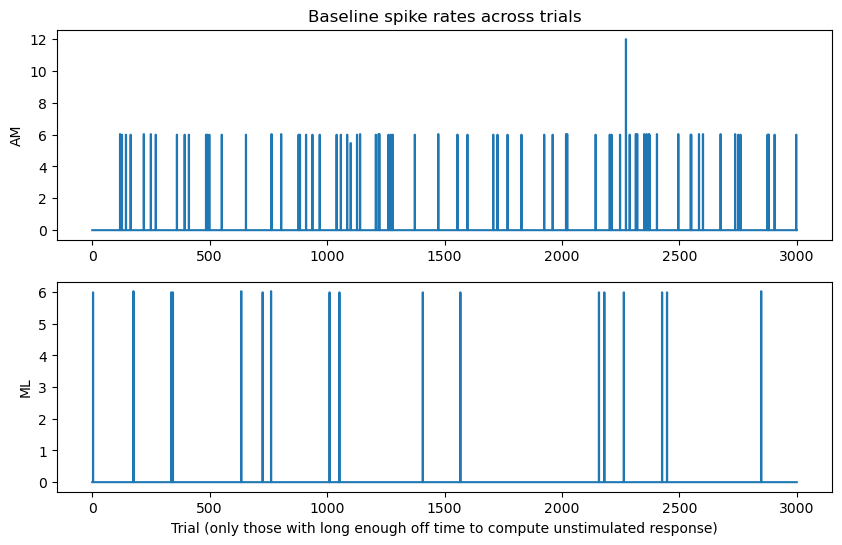

In [13]:
AM_ind = 101
ML_ind = 157

plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
unit = AM_sort_inds_base[AM_ind]
plt.step(np.arange(len(AM_spont_rates_all[unit])), AM_spont_rates_all[unit])
plt.title("Baseline spike rates across trials")
plt.ylabel("AM")

plt.subplot(2,1,2)
unit = ML_sort_inds_base[ML_ind]
plt.step(np.arange(len(ML_spont_rates_all[unit])), ML_spont_rates_all[unit])
plt.xlabel("Trial (only those with long enough off time to compute unstimulated response)")
plt.ylabel("ML")

In [14]:
def custom_lr_func(X, y, numCV, verbose=False):

    N = numCV  # Number of folds for cross-validation

    kf = KFold(n_splits=N, shuffle=True, random_state=42)

    losses = []

    for train_index, test_index in kf.split(y):
        Xtrain, Xtest = X[train_index, :], X[test_index, :]
        Ytrain, Ytest = y[train_index], y[test_index]

        # Standardize the data
        scaler = StandardScaler()
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        # Run logistic regression
        clf = LogisticRegression(multi_class="multinomial").fit(Xtrain, Ytrain)
        predictions = clf.predict(Xtest)
        
        # Calculate loss
        loss = hamming_loss(Ytest, predictions)
        losses.append(loss)

    # Output the average loss across all folds
    average_loss = np.mean(losses)
    if verbose: print(f'Average Accuracy (1 - Hamming Loss) across {N} folds: {1-average_loss}')
    return 1-average_loss


In [15]:
numCV = 5
nRem = 10 # number of units to remove at a time


num_units_removed_AM = np.arange(0, AM_numUnits, nRem)
AM_losses = np.zeros(len(num_units_removed_AM))
print("Decoding Region AM: ")
progress_bar = tqdm(total=len(num_units_removed_AM));
for ind, rem_units in enumerate(num_units_removed_AM):
    keep_inds = AM_sort_inds_base[rem_units:]
    AM_losses[ind] = custom_lr_func(AM_all_counts[:, keep_inds], stimIDs, numCV)
    progress_bar.update(1)
progress_bar.close()


num_units_removed_ML = np.arange(0, ML_numUnits, nRem)
ML_losses = np.zeros(len(num_units_removed_ML))
print("Decoding Region ML: ")
progress_bar = tqdm(total=len(num_units_removed_ML));
for ind, rem_units in enumerate(num_units_removed_ML):
    keep_inds = ML_sort_inds_base[rem_units:]
    ML_losses[ind] = custom_lr_func(ML_all_counts[:, keep_inds], stimIDs, numCV)
    progress_bar.update(1)
progress_bar.close()

Decoding Region AM: 


  5%|▌         | 2/38 [01:12<21:10, 35.28s/it]

[AM] Difference between max decoding and deocding with GMM estimated neurons removed: 0.301%
[ML] Difference between max decoding and deocding with GMM estimated neurons removed: 4.821%


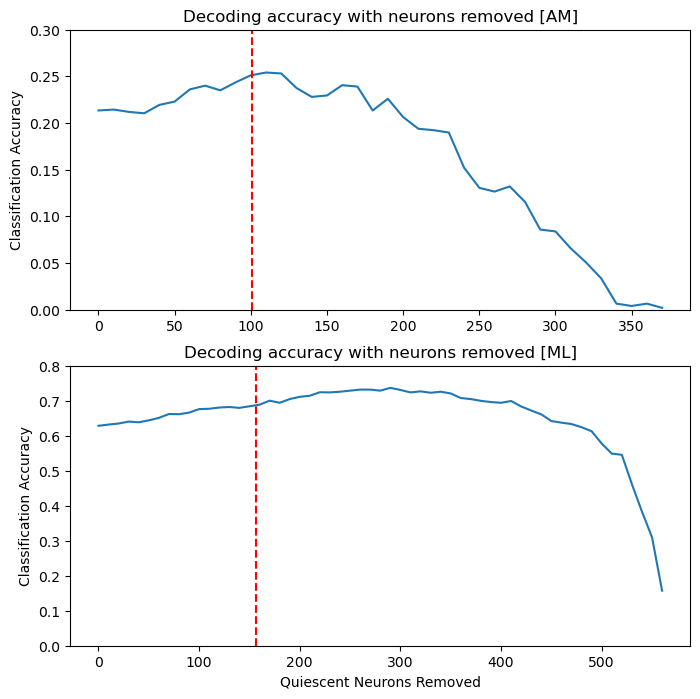

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(2,1,1)
plt.plot(num_units_removed_AM, AM_losses)
plt.axvline(num_quiescent_neurons_removed_AM, linestyle='--', color='r')
plt.title("Decoding accuracy with neurons removed [AM]")
plt.ylabel("Classification Accuracy")
plt.ylim([0, 0.3])


plt.subplot(2,1,2)
plt.plot(num_units_removed_ML, ML_losses)
plt.axvline(num_quiescent_neurons_removed_ML, linestyle='--', color='r')
plt.title("Decoding accuracy with neurons removed [ML]")
plt.ylabel("Classification Accuracy")
plt.ylim([0, 0.8])

plt.xlabel("Quiescent Neurons Removed")

print(f"[AM] Difference between max decoding and deocding with GMM estimated neurons removed: {np.round((np.max(AM_losses) - AM_losses[(np.abs(num_units_removed_AM - num_quiescent_neurons_removed_AM)).argmin()])*100, 3)}%")
print(f"[ML] Difference between max decoding and deocding with GMM estimated neurons removed: {np.round((np.max(ML_losses) - ML_losses[(np.abs(num_units_removed_ML - num_quiescent_neurons_removed_ML)).argmin()])*100, 3)}%")

# Finalize selected neurons

In [ ]:
AM_keep_inds = AM_sort_inds_base[num_quiescent_neurons_removed_AM:]
ML_keep_inds = ML_sort_inds_base[num_quiescent_neurons_removed_ML:]

In [ ]:
save_folder = "/home/marcush/Data/TsaoLabData/split/degraded/keepInds"
save_path_AM = os.path.join(save_folder, os.path.splitext(file_name)[0]+'_keep_inds_AM.pkl')
save_path_ML = os.path.join(save_folder, os.path.splitext(file_name)[0]+'_keep_inds_ML.pkl')

""" 
with open(save_path_AM, 'wb') as file:
    pickle.dump(AM_keep_inds, file)

with open(save_path_ML, 'wb') as file:
    pickle.dump(ML_keep_inds, file)
"""


" \nwith open(save_path_AM, 'wb') as file:\n    pickle.dump(AM_keep_inds, file)\n\nwith open(save_path_ML, 'wb') as file:\n    pickle.dump(ML_keep_inds, file)\n\n"